In [89]:
%matplotlib inline
import string
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly as py
import psycopg2
import textatistic
import random
import seaborn as sns
import requests
from bs4 import BeautifulSoup
matplotlib.style.use('ggplot')
py.offline.init_notebook_mode()
from plotly.offline import iplot
from sklearn.preprocessing import LabelEncoder
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
import math
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
import datetime
%matplotlib inline



In [90]:
from IPython.display import HTML


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### The following analysis is on a dataset from Kaggle about Interview Attendance. The goal is to use predictors such as location, gender, familiarity with the job, marital status, date, skillset, industry, etc. to predict whether a candidate will attend a scheduled interview. I decided to focus on Naive Bayes, Decision Trees, Logistic Regresson, and a Support Vector Machine. 

# Classifying Interview Attendance

In [91]:
pred = pd.read_csv('Interview.csv', parse_dates=['Date of Interview'])
len(pred)

1234

In [92]:
pred.head()

Date of Interview Client name         Industry Location  \
0        13.02.2015     Hospira  Pharmaceuticals  Chennai   
1        13.02.2015     Hospira  Pharmaceuticals  Chennai   
2        13.02.2015     Hospira  Pharmaceuticals  Chennai   
3        13.02.2015     Hospira  Pharmaceuticals  Chennai   
4        13.02.2015     Hospira  Pharmaceuticals  Chennai   

  Position to be closed Nature of Skillset    Interview Type Name(Cand ID)  \
0   Production- Sterile            Routine  Scheduled Walkin   Candidate 1   
1   Production- Sterile            Routine  Scheduled Walkin   Candidate 2   
2   Production- Sterile            Routine  Scheduled Walkin   Candidate 3   
3   Production- Sterile            Routine  Scheduled Walkin   Candidate 4   
4   Production- Sterile            Routine  Scheduled Walkin   Candidate 5   

  Gender Candidate Current Location     ...      \
0   Male                    Chennai     ...       
1   Male                    Chennai     ...       
2   Male                    Chennai     ...       
3   Male                    Chennai     ...       
4   Male                    Chennai     ...       

  Are you clear with the venue details and the landmark.  \
0                                                Yes       
1                                                Yes       
2                                                NaN       
3                                                Yes       
4                                                Yes       

  Has the call letter been shared Expected Attendance Observed Attendance  \
0                             Yes                 Yes                  No   
1                             Yes                 Yes                  No   
2                             NaN           Uncertain                  No   
3                             Yes           Uncertain                  No   
4                             Yes           Uncertain                  No   

  Marital Status Unnamed: 23 Unnamed: 24 Unnamed: 25 Unnamed: 26 Unnamed: 27  
0         Single         NaN         NaN         NaN         NaN         NaN  
1         Single         NaN         NaN         NaN         NaN         NaN  
2         Single         NaN         NaN         NaN         NaN         NaN  
3         Single         NaN         NaN         NaN         NaN         NaN  
4        Married         NaN         NaN         NaN         NaN         NaN  

[5 rows x 28 columns]

# Change Column Names and Make Day, Month, Year Columns

In [93]:
pred.columns

Index(['Date of Interview', 'Client name', 'Industry', 'Location',
       'Position to be closed', 'Nature of Skillset', 'Interview Type',
       'Name(Cand ID)', 'Gender', 'Candidate Current Location',
       'Candidate Job Location', 'Interview Venue',
       'Candidate Native location',
       'Have you obtained the necessary permission to start at the required time',
       'Hope there will be no unscheduled meetings',
       'Can I Call you three hours before the interview and follow up on your attendance for the interview',
       'Can I have an alternative number/ desk number. I assure you that I will not trouble you too much',
       'Have you taken a printout of your updated resume. Have you read the JD and understood the same',
       'Are you clear with the venue details and the landmark.',
       'Has the call letter been shared', 'Expected Attendance',
       'Observed Attendance', 'Marital Status', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unname

In [94]:
pred.columns= ['date', 'name','industry', 'location',
       'position', 'skillset', 'type',
       'cand_id', 'gender', 'current_location',
       'job_location', 'venue',
       'native_location',
       'permission',
       'unsched_meeting',
       'followup_call',
       'alternate_num',
       'read_and_understood',
       'clear_location',
       'call_letter', 'expected_attendance',
       'attended', 'married', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27']

In [95]:
pred=pred.drop(['Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27'], axis=1)

In [96]:
len(pred.date)

1234

In [97]:
pred.date.unique()

array(['13.02.2015', '19.06.2015', '23.06.2015', '29.06.2015',
       '25.06.2015', '25.05.16', '25.5.2016', '25-05-2016', '25.05.2016',
       '25-5-2016', '04/12/16', '13.04.2016', '27.02.2016', '07.05.2016',
       '5.5.16', '4.5.16', '21.4.16', '22.4.16', '23.4.16', '15 Apr 16',
       '19 Apr 16', '20 Apr 16', '21-Apr -16', '22 -Apr -16',
       '25 – Apr-16', '25 Apr 16', '18 Apr 16', '11.5.16', '10.5.16',
       '11.05.16', '12.04.2016', '12.04.2017', '12.04.2018', '12.04.2019',
       '12.04.2020', '12.04.2021', '12.04.2022', '12.04.2023', '8.5.16',
       '7.5.16', '19.03.16', '24.05.2016', '05/11/2016', '26/05/2016',
       '10.05.2016', '28.08.2016 & 09.00 AM', '28.08.2016 & 9.30 AM',
       '28.8.2016 & 12.00 PM', '28.08.2016 & 09.30 AM',
       '28.8.2016 & 10.30 AM', '28.8.2016 & 09.30 AM',
       '28.8.2016 & 04.00 PM', '28.08.2016 & 11.30 AM',
       '28.08.2016 & 11.00 AM', '28.08.2016 & 10.30 AM',
       '28.8.2016 & 03.00 PM', '28.08.2016 & 10.00 AM',
       '28.8.20

In [98]:
#cleaning the dates since they are all in different formats
def clean_date(date):
    date = date.str.strip()
    date = date.str.split("&").str[0]
    date = date.str.replace('–', '/')
    date = date.str.replace('.', '/')
    date = date.str.replace('Apr', '04')
    date = date.str.replace('-', '/')
    date = date.str.replace(' ', '/')
    date = date.str.replace('//+', '/')
    return date

In [99]:
#new date column
pred['newdate'] = clean_date(pred['date'])
pred.drop(pred.index[[1233]], inplace = True)  #this row has many missing values including date

In [100]:
#making a year, day, and month columns
pred['year'] = pred['newdate'].str.split("/").str[2]
pred['day'] = pred['newdate'].str.split("/").str[0]
pred['month'] = pred['newdate'].str.split("/").str[1]


pred['year'].replace(['16', '15'], ['2016', '2015'], inplace = True)


pred['finaldate'] = pd.to_datetime(pd.DataFrame({'year': pred['year'],
                                            'month': pred['month'],
                                            'day': pred['day']}), format = '%Y-%m-%d')
pred.head()

date     name         industry location             position  \
0  13.02.2015  Hospira  Pharmaceuticals  Chennai  Production- Sterile   
1  13.02.2015  Hospira  Pharmaceuticals  Chennai  Production- Sterile   
2  13.02.2015  Hospira  Pharmaceuticals  Chennai  Production- Sterile   
3  13.02.2015  Hospira  Pharmaceuticals  Chennai  Production- Sterile   
4  13.02.2015  Hospira  Pharmaceuticals  Chennai  Production- Sterile   

  skillset              type      cand_id gender current_location    ...      \
0  Routine  Scheduled Walkin  Candidate 1   Male          Chennai    ...       
1  Routine  Scheduled Walkin  Candidate 2   Male          Chennai    ...       
2  Routine  Scheduled Walkin  Candidate 3   Male          Chennai    ...       
3  Routine  Scheduled Walkin  Candidate 4   Male          Chennai    ...       
4  Routine  Scheduled Walkin  Candidate 5   Male          Chennai    ...       

  clear_location call_letter expected_attendance attended  married  \
0            Yes         Yes                 Yes       No   Single   
1            Yes         Yes                 Yes       No   Single   
2            NaN         NaN           Uncertain       No   Single   
3            Yes         Yes           Uncertain       No   Single   
4            Yes         Yes           Uncertain       No  Married   

      newdate  year day month  finaldate  
0  13/02/2015  2015  13    02 2015-02-13  
1  13/02/2015  2015  13    02 2015-02-13  
2  13/02/2015  2015  13    02 2015-02-13  
3  13/02/2015  2015  13    02 2015-02-13  
4  13/02/2015  2015  13    02 2015-02-13  

[5 rows x 28 columns]

In [101]:
data = pred.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [102]:
data.head()

date     name         industry location             position  \
0  13.02.2015  Hospira  Pharmaceuticals  Chennai  Production- Sterile   
1  13.02.2015  Hospira  Pharmaceuticals  Chennai  Production- Sterile   
2  13.02.2015  Hospira  Pharmaceuticals  Chennai  Production- Sterile   
3  13.02.2015  Hospira  Pharmaceuticals  Chennai  Production- Sterile   
4  13.02.2015  Hospira  Pharmaceuticals  Chennai  Production- Sterile   

  skillset              type      cand_id gender current_location    ...      \
0  Routine  Scheduled Walkin  Candidate 1   Male          Chennai    ...       
1  Routine  Scheduled Walkin  Candidate 2   Male          Chennai    ...       
2  Routine  Scheduled Walkin  Candidate 3   Male          Chennai    ...       
3  Routine  Scheduled Walkin  Candidate 4   Male          Chennai    ...       
4  Routine  Scheduled Walkin  Candidate 5   Male          Chennai    ...       

  clear_location call_letter expected_attendance attended  married  \
0            Yes         Yes                 Yes       No   Single   
1            Yes         Yes                 Yes       No   Single   
2            NaN         NaN           Uncertain       No   Single   
3            Yes         Yes           Uncertain       No   Single   
4            Yes         Yes           Uncertain       No  Married   

      newdate  year day month  finaldate  
0  13/02/2015  2015  13    02 2015-02-13  
1  13/02/2015  2015  13    02 2015-02-13  
2  13/02/2015  2015  13    02 2015-02-13  
3  13/02/2015  2015  13    02 2015-02-13  
4  13/02/2015  2015  13    02 2015-02-13  

[5 rows x 28 columns]

In [103]:


data['local'] = np.where((data['job_location'] == data['current_location'])
                     , 1, 0)

I created a new variable called local that indicates whether the job_location is equal to the current location. I also later drop name and the full date as well as the client_id numbers. 

In [104]:
#pred.dtypes

In [105]:
for col in data.columns:
    data[col] = data[col].astype('category')

# More Exploration

In [106]:
pd.crosstab(data['married'], data['gender'])

gender   Female  Male
married              
Married     156   310
Single      112   655

In [107]:
data.groupby(['attended', 'gender']).size()

attended  gender
NO        Female      7
          Male       28
No        Female     92
          Male      315
Yes       Female    152
          Male      549
no        Male        8
yes       Female     17
          Male       65
dtype: int64

In [108]:
pd.crosstab(data['gender'], data['attended'])


attended  NO   No  Yes  no  yes
gender                         
Female     7   92  152   0   17
Male      28  315  549   8   65

In [109]:
#differences in Gender
print('Proportion of Females that attended their interview: ', round((152+17)/(7+92+152+17)*100,4), '%')
print('Proportion of Males that attended their interview:   ', round((549+65)/(28+315+549+8+65)*100,4), '%')

Proportion of Females that attended their interview:  63.0597 %
Proportion of Males that attended their interview:    63.6269 %


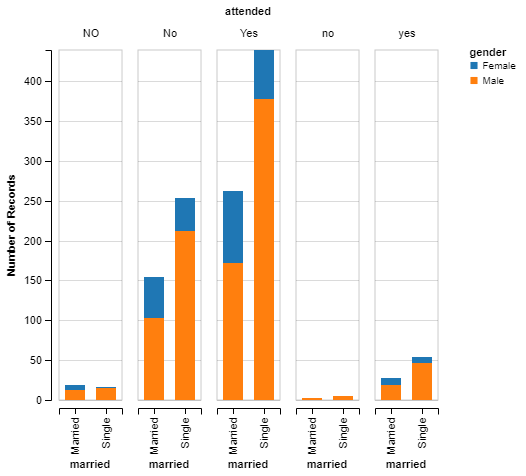

In [110]:
import altair
altair.Chart(data).mark_bar().encode(x='married' ,color='gender', column='attended', y='count(*)')

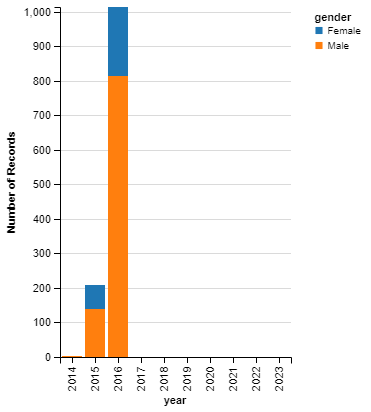

In [111]:
import altair
altair.Chart(data).mark_bar().encode(x='year' ,color='gender', y='count(*)')

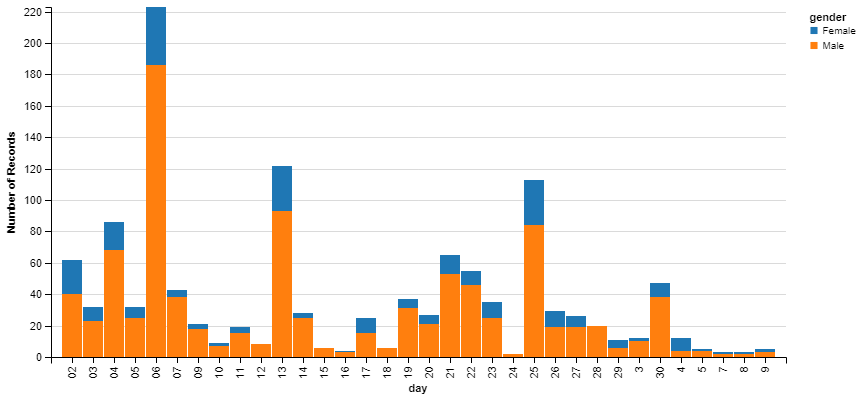

In [112]:
import altair
altair.Chart(data).mark_bar().encode(x='day' ,color='gender', y='count(*)')
#as we can see, the dates columns are generally very inconsistently labeled


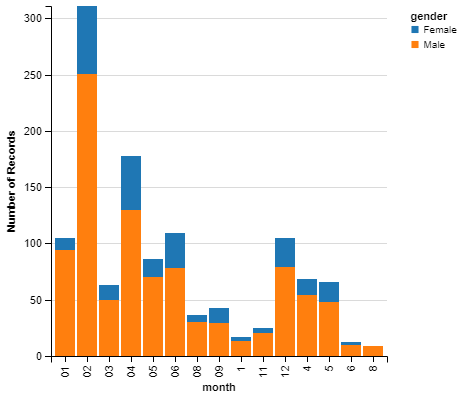

In [113]:
import altair
altair.Chart(data).mark_bar().encode(x='month' ,color='gender', y='count(*)')

## Encoding the Data

In [114]:
#dropping unneeded columns
data.drop('date', axis=1, inplace=True)
data.drop('finaldate', axis=1, inplace=True)

In [115]:
#Label encode the data

data1 = pd.get_dummies(data, columns=['industry', 'location',
       'position', 'skillset', 'type', 'gender', 'current_location',
       'job_location', 'venue',
       'native_location',
       'permission',
       'unsched_meeting',
       'followup_call',
       'alternate_num',
       'read_and_understood',
       'clear_location',
       'call_letter', 'expected_attendance', 'married', 'month', 'year', 'day'])

In [116]:
labels = data1['attended']
print(labels.head())
coded_labels_dict = {'NO': 0, 'No':0, 'no':0, ' no':0, 'no ':0, ' No':0, 'No ':0, 'Yes':1, 'yes':1, ' yes':1, 'yes ':1}
new_labels = labels.map(coded_labels_dict)

0    No
1    No
2    No
3    No
4    No
Name: attended, dtype: category
Categories (5, object): [NO, No, Yes, no, yes]


In [117]:
data1.drop('attended', axis=1, inplace=True)
#pred1.drop('cand_id', axis=1, inplace=True)
#pred1.drop('year', axis=1, inplace=True)
#pred1.drop('day', axis=1, inplace=True)
#pred1.drop('month', axis=1, inplace=True)

data1.drop('newdate', axis=1, inplace=True)


In [118]:
new_labels = new_labels.dropna()
len(new_labels)

1233

In [119]:
data1 = data1.drop('cand_id', axis=1)
data1 = data1.drop('name', axis=1)
#data1 = data1.drop('date', axis=1)
#data1 = data1.drop('newdate', axis=1)
#data1 = data1.drop('finaldate', axis=1)


In [120]:
data1.head()

local  industry_BFSI  industry_Electronics  industry_IT  \
0     0              0                     0            0   
1     0              0                     0            0   
2     1              0                     0            0   
3     1              0                     0            0   
4     0              0                     0            0   

   industry_IT Products and Services  industry_IT Services  \
0                                  0                     0   
1                                  0                     0   
2                                  0                     0   
3                                  0                     0   
4                                  0                     0   

   industry_Pharmaceuticals  industry_Telecom  location_- Cochin-  \
0                         1                 0                   0   
1                         1                 0                   0   
2                         1                 0                   0   
3                         1                 0                   0   
4                         1                 0                   0   

   location_Bangalore  ...    day_27  day_28  day_29  day_3  day_30  day_4  \
0                   0  ...         0       0       0      0       0      0   
1                   0  ...         0       0       0      0       0      0   
2                   0  ...         0       0       0      0       0      0   
3                   0  ...         0       0       0      0       0      0   
4                   0  ...         0       0       0      0       0      0   

   day_5  day_7  day_8  day_9  
0      0      0      0      0  
1      0      0      0      0  
2      0      0      0      0  
3      0      0      0      0  
4      0      0      0      0  

[5 rows x 312 columns]

# Naive Bayes

In [121]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data1,new_labels,test_size=0.2,random_state=4)

In [122]:
from sklearn.naive_bayes import GaussianNB
model_naive = GaussianNB()
model_naive.fit(X_train, Y_train)

GaussianNB(priors=None)

In [123]:
ypred = model_naive.predict(X_test)

In [124]:
NB_ac = round(accuracy_score(Y_test, ypred), 4)

In [125]:
NB_roc = round(roc_auc_score(Y_test, ypred), 4)

In [126]:
print(classification_report(Y_test, ypred))

             precision    recall  f1-score   support

          0       0.41      0.94      0.57       100
          1       0.70      0.10      0.17       147

avg / total       0.58      0.44      0.33       247



In [127]:
NB_cm = confusion_matrix(Y_test, ypred)

# Logistic Regression

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

model_LR= LogisticRegression()

In [129]:
model_LR.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [130]:
pred5 =model_LR.predict(X_test)

In [131]:
log_ac = round(accuracy_score(Y_test, pred5), 4)

In [132]:
log_roc = round(roc_auc_score(Y_test, pred5), 4)

In [133]:
print(classification_report(Y_test, pred5))

             precision    recall  f1-score   support

          0       0.67      0.41      0.51       100
          1       0.68      0.86      0.76       147

avg / total       0.68      0.68      0.66       247



In [134]:
log_cm = confusion_matrix(Y_test, pred5)

# Decision Tree

In [135]:
import math
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(max_features='auto',max_leaf_nodes=10, max_depth= (len(data1))**(1/2))

In [136]:
model_tree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini',
            max_depth=35.11409973215888, max_features='auto',
            max_leaf_nodes=10, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [137]:
ypred = model_tree.predict(X_test)
dt_ac = round(accuracy_score(Y_test, ypred), 4)

In [138]:
dt_roc = round(roc_auc_score(Y_test, ypred), 4)

In [139]:
print(classification_report(Y_test, ypred))

             precision    recall  f1-score   support

          0       0.60      0.41      0.49       100
          1       0.67      0.82      0.74       147

avg / total       0.64      0.65      0.64       247



In [140]:
dt_cm = confusion_matrix(Y_test, ypred)

# Support Vector Machine

In [141]:
from sklearn.svm import SVC

classifier = SVC()
classifier.fit(X_train,Y_train)

ypred = classifier.predict(X_test)

sv_ac = round(accuracy_score(Y_test, ypred), 4)

In [142]:
sv_roc = round(roc_auc_score(Y_test, ypred), 4)

In [143]:
print(classification_report(Y_test, ypred))

             precision    recall  f1-score   support

          0       0.59      0.40      0.48       100
          1       0.66      0.81      0.73       147

avg / total       0.63      0.64      0.63       247



In [144]:
svm_cm = confusion_matrix(Y_test, ypred)

# Model Comparison

In [145]:
print('The following are the accuracy scores for the models:')
print( 'Naive Bayes: ' , NB_ac)
print( 'Logistic Regression: ' , log_ac)
print( 'Decision Tree: ', dt_ac)
print( 'Support Vector Machine: ' , sv_ac)

The following are the accuracy scores for the models:
Naive Bayes:  0.4372
Logistic Regression:  0.6802
Decision Tree:  0.6518
Support Vector Machine:  0.6437


In [146]:
print('The following are the ROC AUC scores for the models:')
print( 'Naive Bayes: ' , NB_roc)
print( 'Logistic Regression: ' , log_roc)
print( 'Decision Tree: ', dt_roc)
print( 'Support Vector Machine: ' , sv_roc)

The following are the ROC AUC scores for the models:
Naive Bayes:  0.5176
Logistic Regression:  0.637
Decision Tree:  0.6132
Support Vector Machine:  0.6048


In [147]:
print('The following are the confusion matrices for the models:')
print( 'Naive Bayes: ')
print(NB_cm)
print( 'Logistic Regression: ')
print(log_cm)
print( 'Decision Tree: ')
print(dt_cm)
print( 'Support Vector Machine: ')
print(svm_cm)

The following are the confusion matrices for the models:
Naive Bayes: 
[[ 94   6]
 [133  14]]
Logistic Regression: 
[[ 41  59]
 [ 20 127]]
Decision Tree: 
[[ 41  59]
 [ 27 120]]
Support Vector Machine: 
[[ 40  60]
 [ 28 119]]


### Logistic Regression has the best accuracy score, and the best AUC score. Naive Bayes has the worst accuracy score and AUC score. The confusion matrices are all very similar, but logistic regression produces more true positives and fewer false negatives. All of these metrics indicate logistic regression is the most successful model when predicting interview attendance. 

# Investigate Failures

In [148]:
pred5

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0])

In [149]:
predictions = pred5
list1 = []
for input, prediction, label in zip(X_test.index, predictions, Y_test):
  if prediction != label:
    list1.append(input)
    print(input, 'has been classified as ', prediction, 'and should be ', label) 

1058 has been classified as  1 and should be  0
878 has been classified as  1 and should be  0
288 has been classified as  1 and should be  0
649 has been classified as  1 and should be  0
92 has been classified as  1 and should be  0
1035 has been classified as  1 and should be  0
270 has been classified as  1 and should be  0
178 has been classified as  1 and should be  0
616 has been classified as  1 and should be  0
326 has been classified as  1 and should be  0
595 has been classified as  0 and should be  1
1016 has been classified as  1 and should be  0
31 has been classified as  1 and should be  0
435 has been classified as  1 and should be  0
58 has been classified as  1 and should be  0
1232 has been classified as  0 and should be  1
427 has been classified as  0 and should be  1
258 has been classified as  1 and should be  0
357 has been classified as  1 and should be  0
328 has been classified as  0 and should be  1
897 has been classified as  0 and should be  1
1167 has bee

In [150]:
print(len(list1))
incorrect = data1.iloc[list1,:]

79


In [151]:
len(incorrect)

79

In [152]:
correct = data1.drop(data1.index[list1])


In [153]:
rat1 = incorrect.sum()#/incorrect.count()



rat2 = correct.sum()#/correct.count()

(array([271.,  11.,   3.,   6.,   2.,   1.,   3.,  10.,   1.,   4.]),
 array([ 0. ,  7.1, 14.2, 21.3, 28.4, 35.5, 42.6, 49.7, 56.8, 63.9, 71. ]),
 <a list of 10 Patch objects>)

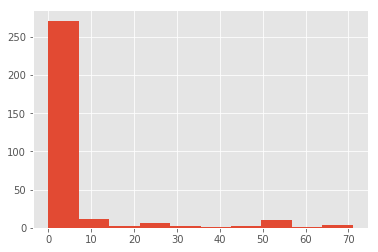

In [154]:

plt.hist(rat1)

(array([270.,   9.,  11.,   1.,   2.,   1.,   0.,   3.,  10.,   5.]),
 array([  0. ,  99.6, 199.2, 298.8, 398.4, 498. , 597.6, 697.2, 796.8,
        896.4, 996. ]),
 <a list of 10 Patch objects>)

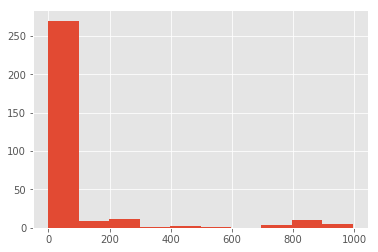

In [155]:
plt.hist(rat2)

In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

model_LR= LogisticRegression()

### I didn't really find a good way to view the incorrect predictions for my data, but looking at the ratios of the sum and counts for the incorrect and the correct data, I don't see any huge differences. 

# Ensemble Learning


In [158]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

In [159]:
eclf = VotingClassifier(estimators=[('lr', model_LR), ('tree', model_tree), ('gnb', model_naive), ('svm', classifier)], voting='hard')


In [160]:
for clf, label in zip([model_LR, model_tree, model_naive, classifier, eclf], ['Logistic Regression', 'Decision Tree', 'naive Bayes', 'Support Vector Machine', 'Ensemble']):
    scores = cross_val_score(clf, X_test, Y_test, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.63 (+/- 0.06) [Logistic Regression]
Accuracy: 0.62 (+/- 0.06) [Decision Tree]
Accuracy: 0.65 (+/- 0.05) [naive Bayes]
Accuracy: 0.60 (+/- 0.00) [Support Vector Machine]
Accuracy: 0.64 (+/- 0.05) [Ensemble]


In [161]:

eclf.fit(X_train,Y_train)
ypred = eclf.predict(X_test)

In [162]:
em_cm = confusion_matrix(Y_test, ypred)

In [163]:
em_roc = round(roc_auc_score(Y_test, ypred), 4) #the ensemble learning model has the best roc_auc score

In [164]:
print('The following are the confusion matrices for the models:')
print( 'Naive Bayes: ')
print(NB_cm)
print( 'Logistic Regression: ')
print(log_cm)
print( 'Decision Tree: ')
print(dt_cm)
print( 'Support Vector Machine: ')
print(svm_cm)
print( 'Ensemble Model ')
print(em_cm)

The following are the confusion matrices for the models:
Naive Bayes: 
[[ 94   6]
 [133  14]]
Logistic Regression: 
[[ 41  59]
 [ 20 127]]
Decision Tree: 
[[ 41  59]
 [ 27 120]]
Support Vector Machine: 
[[ 40  60]
 [ 28 119]]
Ensemble Model 
[[ 54  46]
 [ 34 113]]


In [165]:
print('The following are the ROC AUC scores for the models:')
print( 'Naive Bayes: ' , NB_roc)
print( 'Logistic Regression: ' , log_roc)
print( 'Decision Tree: ', dt_roc)
print( 'Support Vector Machine: ' , sv_roc)
print( 'Ensemble Model: ', em_roc)

The following are the ROC AUC scores for the models:
Naive Bayes:  0.5176
Logistic Regression:  0.637
Decision Tree:  0.6132
Support Vector Machine:  0.6048
Ensemble Model:  0.6544


# Ensemble Model with GridSearch

In [166]:

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200],}

grid = GridSearchCV(estimator=eclf, param_grid=params)
grid = grid.fit(X_train, Y_train)

In [167]:
ypred = grid.predict(X_test)
roc_auc_score(Y_test, ypred)

0.5962925170068027

In [168]:
accuracy_score(Y_test, ypred)

0.5708502024291497

# Randomized Search Tuning with Logistic Regression


In [169]:
tuned_parameters = {'penalty' : ['l1', 'l2'], 'C': range(1, 100, 2), 
                   'solver': ['liblinear', 'saga']
                   }





LRR = LogisticRegression()

from sklearn.model_selection import RandomizedSearchCV
DD_model = RandomizedSearchCV(LRR, tuned_parameters, cv=5, scoring='roc_auc',
                             n_iter=20, n_jobs= 1 , random_state=5)

In [170]:
DD_model.fit(X_train, Y_train)
ypred = DD_model.predict(X_test)

In [171]:
RSLR_roc = round(roc_auc_score(Y_test, ypred), 4)

In [172]:
print('The following are the ROC AUC scores for the models:')
print( 'Naive Bayes: ' , NB_roc)
print( 'Logistic Regression: ' , log_roc)
print( 'Decision Tree: ', dt_roc)
print( 'Support Vector Machine: ' , sv_roc)
print( 'Ensemble Model: ', em_roc)
print( 'Randomized Search with Logistic Regression: ', RSLR_roc)

The following are the ROC AUC scores for the models:
Naive Bayes:  0.5176
Logistic Regression:  0.637
Decision Tree:  0.6132
Support Vector Machine:  0.6048
Ensemble Model:  0.6544
Randomized Search with Logistic Regression:  0.6336


### The ensemble model ended up having the best ROC AUC score of 0.6544